# Тестовое задание Data Science

## Задача

Создать прогностическую модель рисков беременных.

**Срок**: до 1 недели. <br>
**Метрика**: определяется исполнителем.  <br>
**Особенности**: В последних ячейках необходимо вывести метрики и матрицу ошибок на трейне и тесте.

**Описание признаков**: <br>
Age: Age in years when a woman is pregnant. <br>
SystolicBP: Upper value of Blood Pressure in mmHg, another significant attribute during pregnancy. <br>
DiastolicBP: Lower value of Blood Pressure in mmHg, another significant attribute during pregnancy.<br>
BS: Blood glucose levels is in terms of a molar concentration, mmol/L. <br>
HeartRate: A normal resting heart rate in beats per minute. <br>
Risk Level: Predicted Risk Intensity Level during pregnancy considering the previous attribute.ibute.

## Загрузка и разведочный анализ данных

Подключим необходимые библиотеки, зафиксируем `RANDOM_STATE`.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import phik

from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import StandardScaler

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from IPython.display import Markdown, display

RANDOM_STATE = 876543

import warnings
warnings.filterwarnings('ignore')

Загрузим датасет в переменную `df` и посмотрим общую информацию о данных.

In [2]:
df = pd.read_csv('Maternal Health Risk Data Set.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [4]:
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [5]:
df.describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


In [6]:
df.duplicated().sum()

562

Пропуски отсутствуют, все данные представлены в корректных форматах. Однако из метода `describe` видно, что есть аномалии: значения `HeartRate` равные 7 точно выбросы, а вот на объекты с `SystolicBP` 160 надо посмотреть внимательнее. Бросается в глаза небольшой объём данных: 1014 объектов. Нейросети и бустинги не подойдут для этой задачи. Так же очень расстраивает большое количество дубликатов в пропорции на наш небольшой объём данных: 562, что составляет более половины от всех данных. Нужно посмотреть на эти дубликаты, чтобы определить их природу и решить, что с ними делать.

In [7]:
df.loc[df.duplicated()].head(20)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
67,19,120,80,7.0,98.0,70,mid risk
72,19,120,80,7.0,98.0,70,mid risk
97,19,120,80,7.0,98.0,70,mid risk
106,50,140,90,15.0,98.0,90,high risk
107,25,140,100,6.8,98.0,80,high risk
118,32,140,100,7.9,98.0,78,high risk
119,30,140,100,15.0,98.0,70,high risk
129,48,120,80,11.0,98.0,88,high risk
130,40,160,100,19.0,98.0,77,high risk
131,32,140,90,18.0,98.0,88,high risk


Посмотрим на распределения каждого признака.

In [8]:
print(sorted(df.SystolicBP.unique()), sep='')

[70, 75, 76, 78, 80, 83, 85, 90, 95, 99, 100, 110, 115, 120, 129, 130, 135, 140, 160]


In [9]:
print(sorted(df.DiastolicBP.unique()), sep='')

[49, 50, 60, 63, 65, 68, 69, 70, 75, 76, 80, 85, 89, 90, 95, 100]


In [10]:
print(sorted(df.BS.unique()), sep='')

[6.0, 6.1, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.01, 7.1, 7.2, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 15.0, 16.0, 17.0, 18.0, 19.0]


In [11]:
sorted(df.BodyTemp.unique())

[98.0, 98.4, 98.6, 99.0, 100.0, 101.0, 102.0, 103.0]

In [12]:
sorted(df.HeartRate.unique())

[7, 60, 65, 66, 67, 68, 70, 75, 76, 77, 78, 80, 82, 86, 88, 90]

Судя по распределениям признаков значения идут в основном с постоянным шагом. В таких условиях можно ожидать, что результаты будут повторяться. Однако во время предварительного обзора было обнаружено следующее:

In [13]:
df[df.HeartRate == 7]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
499,16,120,75,7.9,98.0,7,low risk
908,16,120,75,7.9,98.0,7,low risk


In [14]:
df[df.SystolicBP == 160]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
123,40,160,100,19.0,98.0,77,high risk
130,40,160,100,19.0,98.0,77,high risk
166,40,160,100,19.0,98.0,77,high risk
262,40,160,100,19.0,98.0,77,high risk
362,40,160,100,19.0,98.0,77,high risk
538,40,160,100,19.0,98.0,77,high risk
583,40,160,100,19.0,98.0,77,high risk
689,40,160,100,19.0,98.0,77,high risk
961,40,160,100,19.0,98.0,77,high risk
994,40,160,100,19.0,98.0,77,high risk


Наши аномалии, которые мы выделили в начале показывают, что дубликаты действительно являются дубликатами. Невозможно, чтобы у человека был пульс 7 ударов в минуту (на приёме по скринингу беременности), значит это аномалия. Которая каким-то образом продублировалась! То же самое применимо и к случаю `SystolicBP == 160`. Сложно представить ситуацию, в которой существует 10 пациентов, с таким запредельным давлением и при этом абсолютно одинаковыми остальными показателями. К сожалению, в связи с вышеперечисленным, невозможно доверять и остальным дубликатам. С большой долей вероятности это не реальные даные, удалим их. Да, наши данные сократятся более чем в два раза, но мы избежим переобучения под дублирующиеся нереальные признаки.

Так же тут появляется новый вопрос: когда выделять тестовую выборку? До удаления дубликатов или после? Так как на данный момент связь с заказчиком отсутсвует (в рамках тестового задания), и у нас нету информации о том, будет ли проведена работа по исправлению ситуации с дубликатами, будем исходить из того, что наша модель будет работать на данных, аналогичных представленным, то есть наводнёнными дубликатами. Поэтому тестовую выборку выделим до удаления дубликатов. В данном исследовании модели будут оцениваться по кросс-валидации, поэтому не будем ужимать тренировочные данные за счёт тестовых и на тест выделим стандартные 20% от всех данных. Но сначала всё-таки удалим аномалию `HeartRate == 7`, которая сильно портит распределение этого признака, это очевидная ошибка в данных, которая носит единичный характер.

In [15]:
df = df[df.HeartRate != 7]

In [16]:
X = df.drop('RiskLevel', axis=1)
y = df.RiskLevel

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=RANDOM_STATE,
                                                    shuffle=True,
                                                    stratify=y)

In [17]:
X_train.drop_duplicates(inplace=True)
y_train = y_train[X_train.index]

Посмотрим на распределение классов.

In [18]:
y.value_counts()

RiskLevel
low risk     404
mid risk     336
high risk    272
Name: count, dtype: int64

Наблюдается небольшой дисбаланс. Отметим на будущее.

Посмотрим на распределения данных в зависимости от таргетного класса.

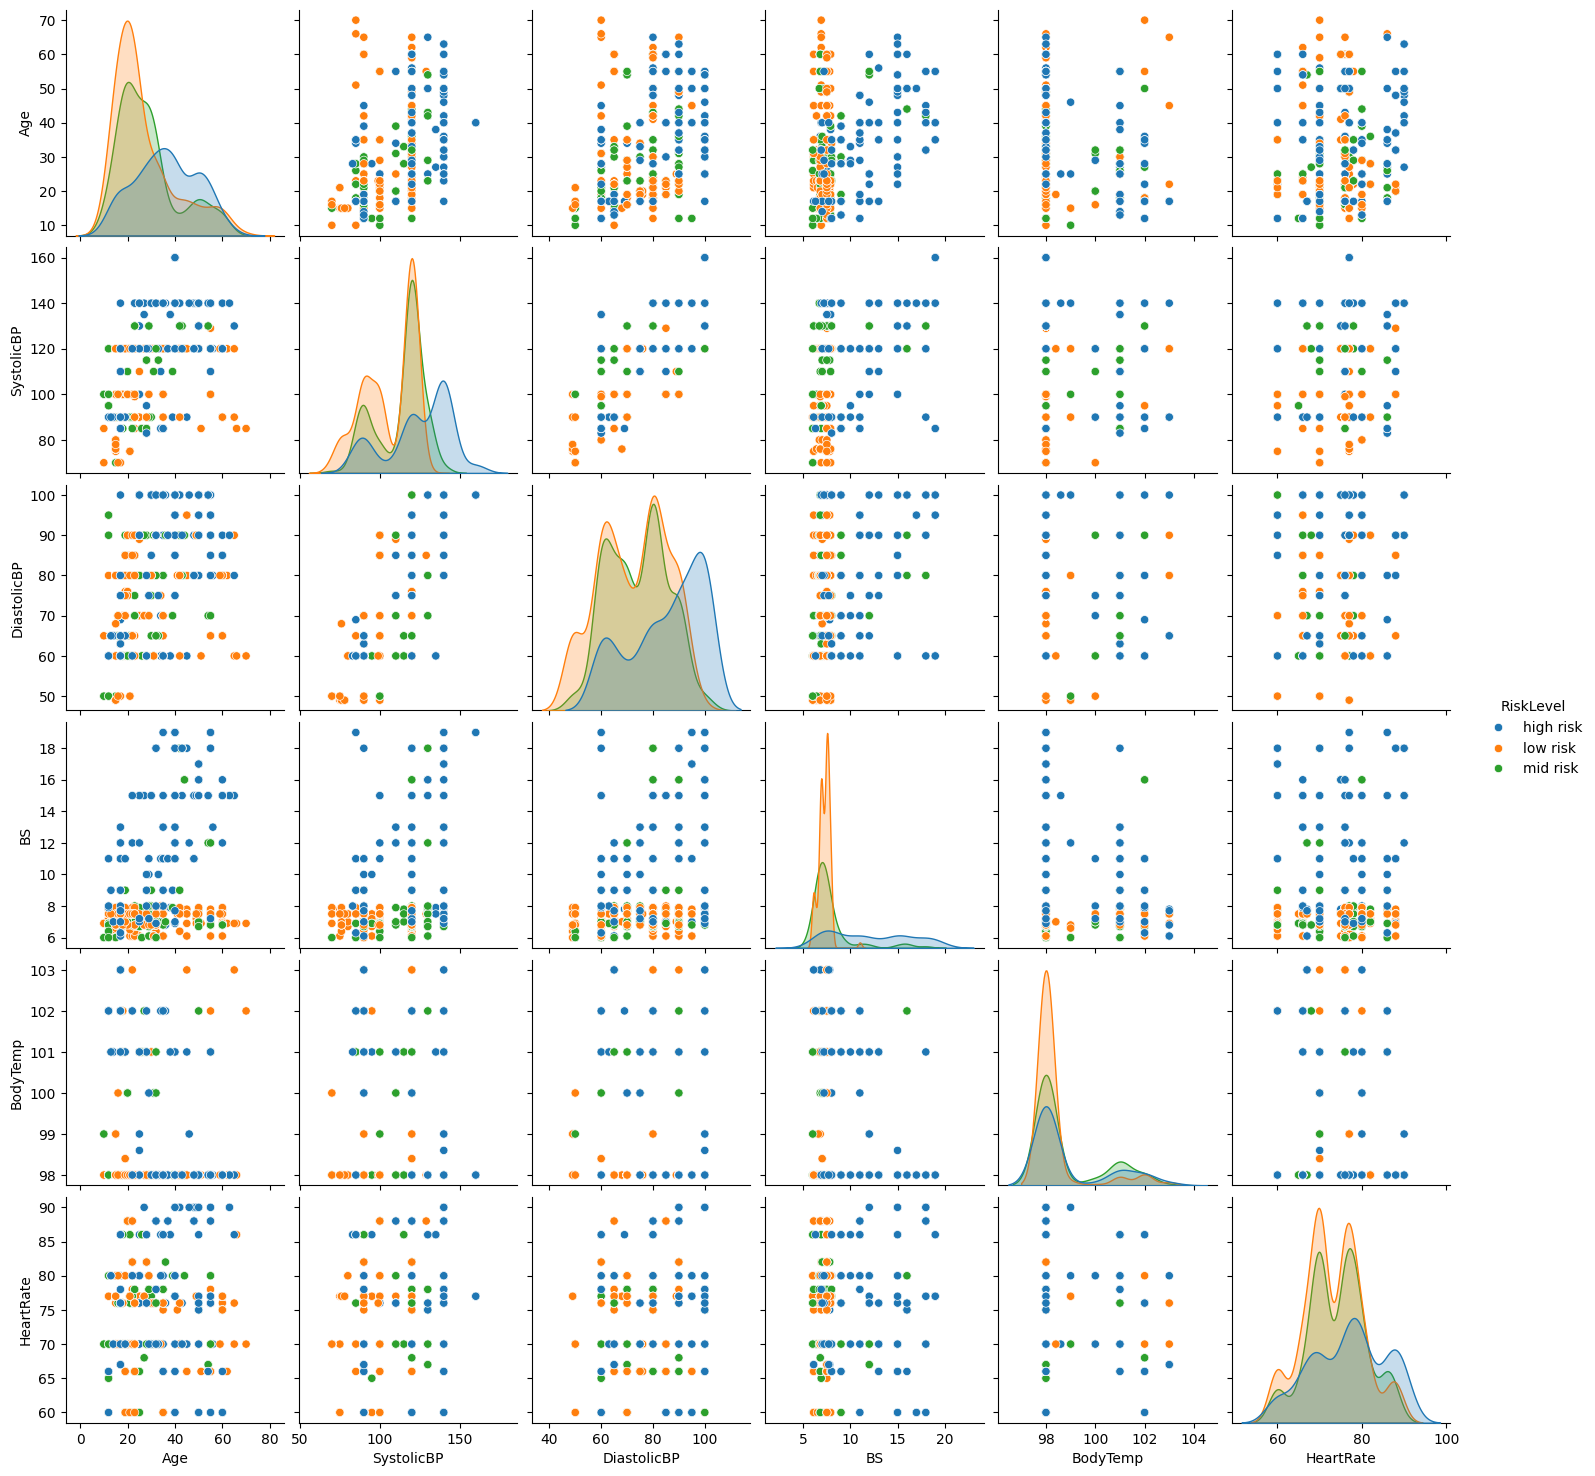

In [19]:
sns.pairplot(X.join(y), hue='RiskLevel');

Классы очень перемешаны. Судя по распределениям, `BS` будет самым важным признаком, потому что остальные признаки не так хорошо отделяют классы. При этом, если общий вид распределений `low risk` и `hish risk` заметно отличается, то `mid risk` содержит в себе характерные признаки двух других распределений. Ожидается, что большей проблемой для модели будет определение именно этого класса.

Осталось посмотреть на корреляции признаков.

interval columns not set, guessing: ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']


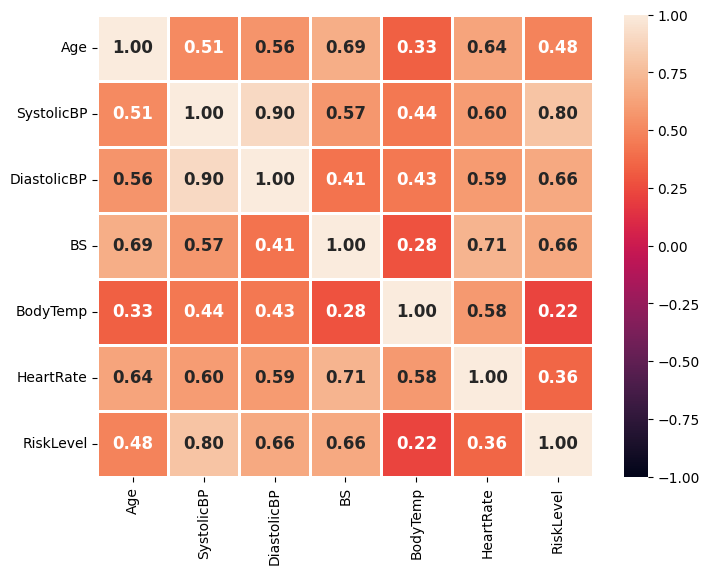

In [20]:
plt.figure(figsize=(8,6))
sns.heatmap(X.join(y).phik_matrix(),
            vmin=-1,
            vmax=1,
            linewidths=1,
            annot=True,
            annot_kws={'fontsize':12, 'fontweight':'bold'},
            fmt='.2f');

`SystolicBP` и `DiastolicBP` имеют довольно большую степень корреляции. Удалим `DiastolicBP`, который менее коррелирован с целевым признаком.

In [21]:
X_train.drop('DiastolicBP', axis=1, inplace=True)
X_test.drop('DiastolicBP', axis=1, inplace=True)

Разведочный анализ данных завершён. Следующим шагом будет выбор метрики и базовой модели, получение стартового значения метрики и создание новых признаков.

## Подготовка к обучению

### Выбор метрики

В нашей задаче мультиклассификации существует выбор между `accuracy` и `f1-score`. У нас есть небольшой дисбаланс классов, однако в дальшейм планируется его устранить с помощью `ADASYN`. Так же, если бы у нас была задача бинарной классификации, например между `low risk` и `high risk`, то выбор `f1-score` был бы очевиден, из-за того что эта метрика зависит от `recall`. Нам это важно, ведь допустимо предсказать `high risk` в случае `low risk`, но не наоборот. Обычно приоритет `precision` или `recall` уточняется у аналитика или продуктового менеджера, но в связи с отсутствием этой возможности предположим, что человеческие риски важнее бюджетных трат на обследование, в случае медицины по ОМС. Тем более задание делается для стартапа, поэтому ложноположительные результаты означают прибыль в виде повода для назначения новых процедур. В общем вопрос сложный, будем исходить из принципа "не навреди". Вернёмся к метрике. Можно было бы использовать даже `fb-score` с `b=2`, чтобы увеличить влияние `recall`. Однако в задачах мультиклассификации используется `accuracy`. Её легко интерпретировать, но стоит контролировать модель с помощью матрицы ошибок, чтобы следить за тем, чтобы модель одинаково хорошо предсказывала все классы.

### Выбор модели

Логистическая регрессия и метод опорных векторов не покажут хорошего результата с такими перемешанными данными. Для бустингов и нейронных сетей данных слишком мало. Остановим свой выбор на случайном лесе.

### Стартовое значение метрики

Посмотрим, насколько хорошо обучается модель на базовых данных, оценивая результат кросс-валидацией со стратификацией. При этом вместо `cross_validate` будем использовть `GridSearchCV` без указания параметров для перебора, так как он возвращает обученную модель.

In [22]:
model_RFC = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid_params = {'estimator': model_RFC,
               'param_grid': dict(),
               'cv': stratified_kfold,
               'scoring': 'accuracy'}

In [23]:
grid_RFC = GridSearchCV(**grid_params)
grid_RFC.fit(X_train, y_train)

display(Markdown(f'Стартовая метрика: **{grid_RFC.best_score_:.4}**'))

Стартовая метрика: **0.7171**

Метрику нужно улучшать.

### UPSAMPLING

Устраним дисбаланс и частично восполним нехватку данных с помощью `ADASYN`, который  генерирует больше синтетических данных для тех образцов, которые считаются более сложными для классификации. Таким образом мы надеемся предоставить модели больше пограничных объектов для обучения работы с ними. При этом уберем параметр `class_weight='balanced'` в случайном лесе и зададим `cv=5` в `GridSearchCV`, так как теперь классы сбалансированны.

In [24]:
X_resampled, y_resampled = ADASYN(random_state=RANDOM_STATE).fit_resample(X_train, y_train)
print("Original dataset:", sorted(Counter(y_train).items()))
print("Sampled dataset:", sorted(Counter(y_resampled).items()))

Original dataset: [('high risk', 98), ('low risk', 202), ('mid risk', 89)]
Sampled dataset: [('high risk', 209), ('low risk', 202), ('mid risk', 186)]


In [25]:
model_RFC = RandomForestClassifier(random_state=RANDOM_STATE)

grid_params['cv'] = 5

grid_RFC = GridSearchCV(**grid_params)
grid_RFC.fit(X_resampled, y_resampled)

display(Markdown(f'Метрика после ADASYN **{grid_RFC.best_score_:.4}**'))

Метрика после ADASYN **0.7757**

Метрика выросла, но недостаточно. Проанализтируем ситуацию. Выведем матрицу ошибок. Придётся подсмотреть в тестовую выборку.

In [26]:
X_train, y_train = X_resampled, y_resampled

In [27]:
def cm(y_real, y_pred):

    '''
    Функция построяния матрицы ошибок
    '''    

    labels = ['low risk', 'mid risk', 'high risk']
    mcm = confusion_matrix(y_real, y_pred, labels=labels)
    plt.figure(figsize=(10,7))
    sns.heatmap(mcm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Предсказанные значения', fontsize=14)
    plt.ylabel('Реальные значения', fontsize=14)
    plt.title('Матрица ошибок', fontsize=18)
    plt.show()

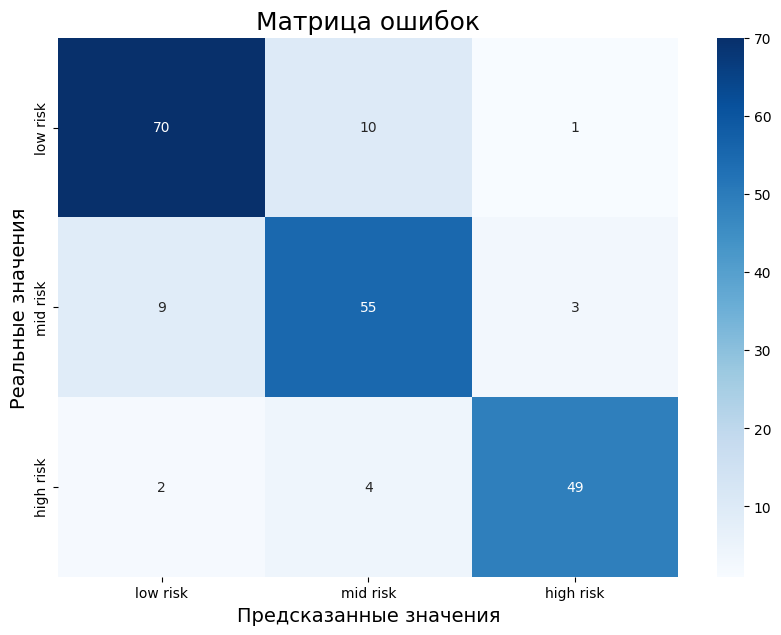

In [28]:
cm(y_test, grid_RFC.predict(X_test))

Как и ожидалось, модели тяжело отличить `mid risk` от других классов и в особенности от `low risk`. Попробуем "подсказать" модели, какие значения параметров являются "нормой" и относятся к категории `low risk`, создав новые признаки.

### Генерация новых признаков

* Согласно открытым данным, `BS` или содержания сахара в крови должно быть меньше 5,1 ммоль/л для всех возрастов в нашей таблице. При этом все значения в нашей таблице начинаются от 6. Подозрительно. Предположим, что пациенты сдавали анализ не натощак, тогда допускается поднятие до 7. Добавим столбец `BS_low`, если значение сахара меньше 7.
* Нормы пульса и систолического давления с возрастом меняются. Учтём это и создадим признаки `is_SBP_ok` и `is_HR_ok`, в которых будет указано, находятся ли пульс и систолическое давление в норме согласно открытым источникам.
* Дисперсия признака `BodyTemp` слишком мала, по нему сложно выделить какие-либо группы.

In [29]:
def is_BS_ok(BS):

    '''
    Функция создания столбца с информацией о том, является ли содержание сахара в крови
    норамальным в этом возрасте
    '''
    
    return 1 if BS <= 7 else 0

In [30]:
def is_SBP_ok(age, SBP):

    '''
    Функция создания столбца с информацией о том, является ли давление нормальным
    в этом возрасте
    '''
    
    if age >= 10 and age <= 16:
        return 1 if 95 <= SBP <= 115 else 0
    elif age > 16 and age <= 20:
        return 1 if 100 <= SBP <= 120 else 0
    elif age > 20 and age <= 40:
        return 1 if 120 <= SBP <= 130 else 0
    elif age > 40 and age <= 70:
        return 1 if SBP <= 140 else 0
    else:
        return 0

In [31]:
def is_HR_ok(age, HR):

    '''
    Функция создания столбца с информацией о том, является ли пульс нормальным
    в этом возрасте
    '''
    
    if age >= 10 and age <= 15:
        return 1 if 60 <= HR <= 100 else 0
    elif age > 15 and age <= 30:
        return 1 if 60 <= HR <= 80 else 0
    elif age > 30 and age <= 70:
        return 1 if 55 <= HR <= 90 else 0
    else:
        return 0

In [32]:
X_train['is_BS_ok'] = X_train.apply(lambda x: is_BS_ok(x['BS']), axis=1)
X_test['is_BS_ok'] = X_test.apply(lambda x: is_BS_ok(x['BS']), axis=1)

X_train['is_SBP_ok'] = X_train.apply(lambda x: is_SBP_ok(x['Age'], x['SystolicBP']), axis=1)
X_test['is_SBP_ok'] = X_test.apply(lambda x: is_SBP_ok(x['Age'], x['SystolicBP']), axis=1)

X_train['is_HR_ok'] = X_train.apply(lambda x: is_HR_ok(x['Age'], x['HeartRate']), axis=1)
X_test['is_HR_ok'] = X_test.apply(lambda x: is_HR_ok(x['Age'], x['HeartRate']), axis=1)

Обучим модель с новыми признаками.

In [33]:
grid_RFC = GridSearchCV(**grid_params)
grid_RFC.fit(X_train, y_train)

display(Markdown(f'Метрика с новыми признаками **{grid_RFC.best_score_:.4}**'))

Метрика с новыми признаками **0.7572**

Метрика ухудшилась. Оценим важность признаков.

In [34]:
def show_coef(names, coef):

    '''
    Функция построения графика важности признаков
    '''
    
    plt.figure(figsize=(10,len(names)*0.5))
    
    df = pd.DataFrame({'names': names, 'coef': coef})
    df = df.sort_values(by='coef', ascending=False)
    names_sorted = df['names']
    coef_sorted = df['coef']

    sbp = sns.barplot(y=names_sorted, x=abs(coef_sorted), orient='h', palette="husl");
    bar_values = [rect.get_width() for rect in sbp.patches]
    
    for rect, value in zip(sbp.patches, bar_values):
        if value > max(bar_values)*.8:
            sbp.annotate(f"{value:.5f}", (value, rect.get_y() + rect.get_height() / 2),
                     xytext=(-10, 0), textcoords='offset points', ha='right', va='center')
        else:
            sbp.annotate(f"{value:.5f}", (value, rect.get_y() + rect.get_height() / 2),
                     xytext=(10, 0), textcoords='offset points', ha='left', va='center')
            
    plt.ylabel(' ')
    plt.title('Важность признаков')
    plt.tight_layout
    plt.show()

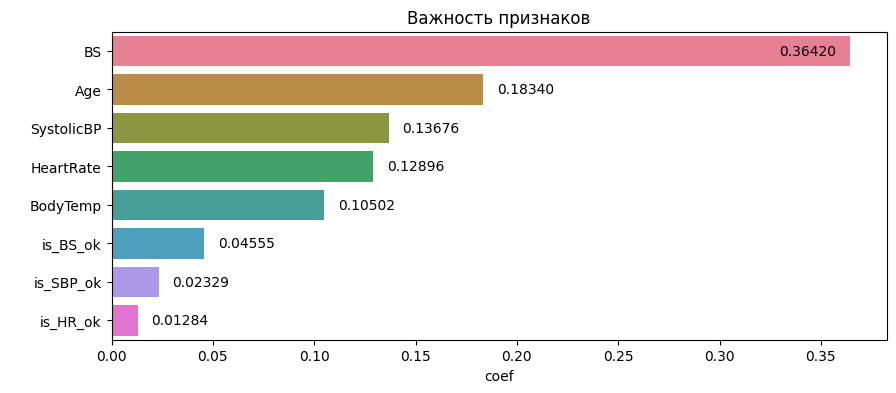

In [35]:
show_coef(X_train.columns, grid_RFC.best_estimator_.feature_importances_)

Видно, что наши новые признаки практически не несут вклада в принятие моделью решений. Интересно почему. Вообще, данные не очень соответствуют нормам из открытых источников. Но это вопрос для другого исследования. А пока удалим новые признаки.

In [36]:
X_train, X_test = X_train.drop(['is_BS_ok', 'is_SBP_ok', 'is_HR_ok'], axis=1), X_test.drop(['is_BS_ok', 'is_SBP_ok', 'is_HR_ok'], axis=1)

Есть ещё один способ лучше разделять классы друг от друга: построить три модели, каждая из которых будет предсказывать свой класс.

## Анализ ансамбля классификаторов

Основная идея ансамбля классификаторов заключается в том, что мы показываем модели в качестве положительного целевого признака один класс, например `low risk`, а два других делаем отрицательным классом. Тогда модель обучается выделять именно этот один положительный признак. Возможно, используя три таких модели для каждого класса удастся получить лучшие предсказания.

### Подготовка

Создадим три новых целевых признака.

In [37]:
y_train_low = (y_train == 'low risk') + 0
y_train_mid = (y_train == 'mid risk') + 0
y_train_high = (y_train == 'high risk') + 0

В `grid_params` добавим сетку параметров, и создадим функцию `grid_search_results` для удобного отображения результатов.

In [38]:
grid_params['param_grid'] = {
                            'max_depth':[3, 7, 12, None], 
                            'n_estimators':[50, 100, 200, 500],
                            'min_samples_leaf':[1, 2, 3],
                            'min_samples_split':[1, 2, 3]
                            }

In [39]:
def grid_search_results(grid):

    '''
    Функция вывода информации о результатах обучения grid
    '''
    
    display(Markdown(f"Время обучения лучшей модели: **{round(grid.refit_time_, 2)}** секунды"))
    display(Markdown(f'Accuracy на кросс валидации: **{grid.best_score_:.4}**'))
    display(Markdown(f'Наилучший набор параметров: {grid.best_params_}'))

### Обучение

Обучим наши модели, каждую на своём классе. 

In [40]:
grid_RFC_low = GridSearchCV(**grid_params)
grid_RFC_low.fit(X_train, y_train_low)

grid_search_results(grid_RFC_low)

Время обучения лучшей модели: **0.24** секунды

Accuracy на кросс валидации: **0.8326**

Наилучший набор параметров: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

In [41]:
grid_RFC_mid = GridSearchCV(**grid_params)
grid_RFC_mid.fit(X_train, y_train_mid)

grid_search_results(grid_RFC_mid)

Время обучения лучшей модели: **0.26** секунды

Accuracy на кросс валидации: **0.7791**

Наилучший набор параметров: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

In [42]:
grid_RFC_high = GridSearchCV(**grid_params)
grid_RFC_high.fit(X_train, y_train_high)

grid_search_results(grid_RFC_high)

Время обучения лучшей модели: **0.11** секунды

Accuracy на кросс валидации: **0.9263**

Наилучший набор параметров: {'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

`accuracy` на валидации моделей наилучшее на данный момент. Так же видно, что `high risk` предсказывается лучше всего, а `mid risk` заметно хуже. Перейдём к предсказаниям на тестовой выборке и `accuracy` по всем трём классам.

### Предсказания

Создадим датафрейм в который поместим информацию о том, какую вероятность на тестовой выборке каждая из моделей присвоила классу, на который она обучена. Минус данного способа в том, что приходится пользоваться тестовой выборкой. Вероятно существуют способы провести кросс-валидацию на для нескольких моделей, как минимум вручную написать такой класс, однако в рамках данного исследования это признано излишним.

In [43]:
result = pd.DataFrame({'low risk': grid_RFC_low.predict_proba(X_test)[:,1],
                       'mid risk': grid_RFC_mid.predict_proba(X_test)[:,1],
                       'high risk': grid_RFC_high.predict_proba(X_test)[:,1]},
                       index=y_test.index)
result.head(10)

,low risk,mid risk,high risk
416,0.125,0.800,0.030000
606,0.985,0.015,0.000000
450,0.865,0.150,0.000000
1010,0.000,0.115,0.820000
461,0.860,0.160,0.000000
927,0.995,0.000,0.000000
213,0.920,0.040,0.020000
32,0.880,0.105,0.000000
503,0.015,0.020,0.973823
933,0.145,0.890,0.000000


Выберем для каждого объекта степень риска, которой соответствует наибольшая вероятность и оценим `accuracy`.

In [44]:
def assign_risk(row):

    '''
    Функция для присвоения каждой строке класса, для которого вероятность
    максимальна
    '''

    max_value = float(row.max())
    
    if row['low risk'] == max_value:
        return 'low risk'
    elif row['mid risk'] == max_value:
        return 'mid risk'
    else:
        return 'high risk'

In [45]:
pred_risk = result.apply(assign_risk, axis=1)

In [46]:
display(Markdown(f'Accuracy на тестовой выборке: **{accuracy_score(y_test, pred_risk):.4}**'))

Accuracy на тестовой выборке: **0.8621**

Результат заметно улучшился, посмотрим на матрицу ошибок.

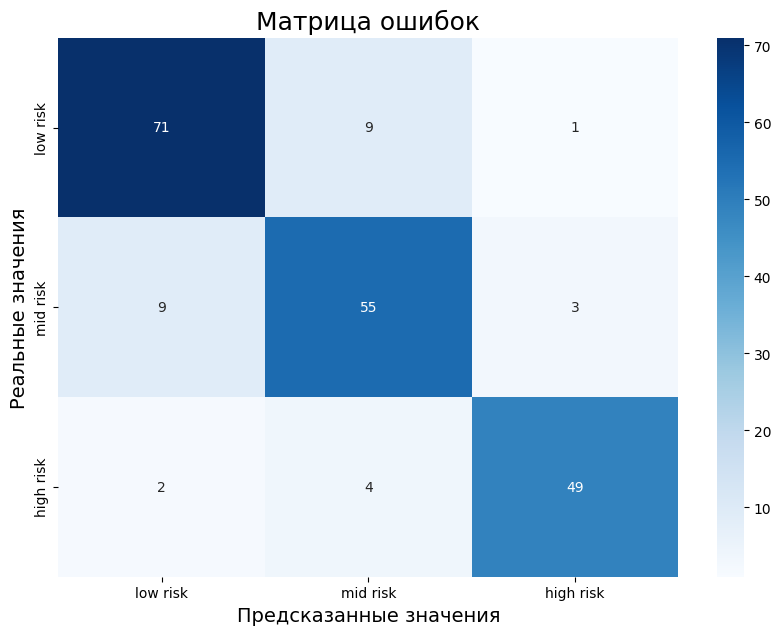

In [47]:
cm(y_test, pred_risk)

Однако матрица ошибок практически идентична той, что мы видели ранее, для одной модели. В ходе данного исследования была обнаружена такая закономерность: кросс-валидация показывала заниженный результат. К сожалению, ансамбль не показал прироста в точности предсказаний и сложность его использования не оправдалась.  Посмотрим на те объекты, на которых предсказания получились неверными.

### Анализ ошибочных предсказаний

In [48]:
result['predicted'] = pred_risk
result['true'] = y_test

result[result['predicted'] != result['true']].merge(X_test, how='left',  left_index=True, right_index=True)

,low risk,mid risk,high risk,predicted,true,Age,SystolicBP,BS,BodyTemp,HeartRate
933,0.145,0.890,0.000000,mid risk,low risk,28,90,7.5,98.0,82
356,0.830,0.205,0.000000,low risk,high risk,35,120,6.9,98.0,80
652,0.235,0.720,0.000000,mid risk,low risk,19,120,7.0,98.0,70
967,0.010,0.745,0.166499,mid risk,high risk,60,120,15.0,98.0,60
810,0.005,0.050,0.980000,high risk,mid risk,48,120,11.0,98.0,88
542,0.145,0.890,0.000000,mid risk,low risk,28,90,7.5,98.0,82
590,0.995,0.005,0.000000,low risk,mid risk,23,100,7.5,98.0,66
547,0.315,0.680,0.000000,mid risk,low risk,21,120,7.5,98.0,77
423,0.260,0.755,0.000000,mid risk,low risk,22,90,6.8,98.0,77
490,0.960,0.085,0.000000,low risk,mid risk,31,120,6.1,98.0,76


Разница предсказанных вероятностей слишком велика, наши модели слишком уверены в предсказаниях, чтобы мы могли с помощью изменения порога увеличить количество верно предсказанных `mid risk`, жертвуя точностью предсказаний `low risk`. Больше `True Positive` - больше `False Positive`. Из таблицы видно, что эти объекты действительно очень плохо предсказываются, поэтому создание ансамбля не помогло. Напоследок отбросим все оговоренные рамки, и попробуем взять этот датасет ансамблем бустингом

## Ансамбль бустингов

В качестве ансамбля используем три популярных бустинга, затем сложим предсказанные ими вероятности классов и выберем наиболее вероятный класс для каждого объекта.

In [49]:
grid_params['estimator'] = LGBMClassifier(random_state=RANDOM_STATE, verbose=-100)

grid_LGBM = GridSearchCV(**grid_params)
grid_LGBM.fit(X_train, y_train)

grid_search_results(grid_LGBM)

Время обучения лучшей модели: **0.06** секунды

Accuracy на кросс валидации: **0.7707**

Наилучший набор параметров: {'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 1, 'n_estimators': 100}

In [50]:
grid_params['estimator'] = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)
grid_params['param_grid'] = [{
              'depth':[6, 9, 12],
              'l2_leaf_reg':[1, 10, 100],
             }]


grid_CB = GridSearchCV(**grid_params)
grid_CB.fit(X_train, y_train)

grid_search_results(grid_CB)

Время обучения лучшей модели: **1.62** секунды

Accuracy на кросс валидации: **0.7891**

Наилучший набор параметров: {'depth': 6, 'l2_leaf_reg': 1}

In [51]:
y_train_XGB = y_train.replace({'low risk': 0, 'mid risk': 1, 'high risk': 2})
y_test_XGB = y_test.replace({'low risk': 0, 'mid risk': 1, 'high risk': 2})

In [52]:
grid_params['estimator'] = XGBClassifier(random_state=RANDOM_STATE, verbose=0)
grid_params['param_grid'] =  [{
        'min_child_weight': [1, 5, 10],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }]

grid_XGB = GridSearchCV(**grid_params)
grid_XGB.fit(X_train, y_train_XGB)

grid_search_results(grid_XGB)

Время обучения лучшей модели: **0.08** секунды

Accuracy на кросс валидации: **0.7774**

Наилучший набор параметров: {'colsample_bytree': 1.0, 'max_depth': 5, 'min_child_weight': 1}

Бустинги показали одинаковые результаты, поэтому не будем добавлять веса к их предсказаниям.

In [53]:
grid_LGBM.best_estimator_.classes_

array(['high risk', 'low risk', 'mid risk'], dtype=object)

In [54]:
LGBM_pred_proba = grid_LGBM.predict_proba(X_test)[:, [1, 2, 0]]

In [55]:
grid_CB.best_estimator_.classes_

array(['high risk', 'low risk', 'mid risk'], dtype=object)

In [56]:
CB_pred_proba = grid_CB.predict_proba(X_test)[:, [1, 2, 0]]

In [57]:
grid_XGB.classes_

array([0, 1, 2])

In [58]:
XGB_pred_proba = grid_XGB.predict_proba(X_test)

In [59]:
boostings_res = LGBM_pred_proba + CB_pred_proba + XGB_pred_proba

In [60]:
max_col = np.argmax(boostings_res, axis=1)

risk_levels = np.where(max_col == 0, 'low risk', np.where(max_col == 1, 'mid risk', 'high risk'))
boostings_answers = pd.Series(risk_levels)

boostings_answers.head()

0     mid risk
1     low risk
2     low risk
3    high risk
4     low risk
dtype: object

In [61]:
display(Markdown(f'Accuracy на тестовой выборке: **{accuracy_score(y_test, boostings_answers):.4}**'))

Accuracy на тестовой выборке: **0.8522**

Метрика не улучшилась. Напоследок проверим, как сработает `StackingClassifier`.

## `StackingClassifier`

Используем `StackingClassifier`. В качестве базовых моделей используем несколько классификаторов и уже обученные бустинги. Финальной моделью установим `LogisticRegression()`. Так как некоторые модели требуют нормализации числовых данных, предварительно применим к данным `StandardScaler()`, обучив его только на тренировочной выборке, чтобы не было утечки.

In [62]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [63]:
estimators = [
     ('ADA', AdaBoostClassifier(random_state=RANDOM_STATE)),
     ('GNB', GaussianNB()),
     ('KNC', KNeighborsClassifier()),
     ('RFC', RandomForestClassifier(random_state=RANDOM_STATE)),
     ('LGBM', grid_LGBM.best_estimator_),
     ('CB', grid_CB.best_estimator_),
     ('XGB', grid_XGB.best_estimator_),
 ]

clf = StackingClassifier(estimators=estimators,
                         final_estimator=LogisticRegression(random_state=RANDOM_STATE),
                         stack_method='predict_proba')

clf.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('ADA', AdaBoostClassifier(random_state=876543)),
                               ('GNB', GaussianNB()),
                               ('KNC', KNeighborsClassifier()),
                               ('RFC',
                                RandomForestClassifier(random_state=876543)),
                               ('LGBM',
                                LGBMClassifier(max_depth=7, min_samples_leaf=3,
                                               min_samples_split=1,
                                               random_state=876543,
                                               verbose=-100)),
                               ('CB',
                                <catboost.core.CatBoostClassifier object at 0x000001D07...
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=5,
                                              max_leaves=None,
                                              min_child_weight=1, missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              objective='multi:softprob', ...))],
                   final_estimator=LogisticRegression(random_state=876543),
                   stack_method='predict_proba')

In [64]:
display(Markdown(f'Accuracy на тестовой выборке: **{accuracy_score(clf.predict(X_test_scaled), y_test):.4}**'))

Accuracy на тестовой выборке: **0.8473**

К сожалению, не удалось улучшить метрику, все её колебания от применения наших методов эквиваленты изменению с помощью подбора `RANDOM_STATE`. Данные в датасете действительно сложно разделимы. Закончим работу выбором лучшей модели и тестированием на тестовой выборке.

## Выбор и тестирование наилучшей модели

Ансамбли не смогли улучшить метрку, а работа с ними сложнее и дольше, поэтому в качестве финальной модели выбереим `RandomForestClassifier`.

In [65]:
grid_params['estimator'] = RandomForestClassifier(random_state=RANDOM_STATE)
grid_params['param_grid'] = {
                            'max_depth':[3, 7, 12, None], 
                            'n_estimators':[50, 100, 200, 500],
                            'min_samples_leaf':[1, 2, 3],
                            'min_samples_split':[1, 2, 3]
                           }

grid_RFC = GridSearchCV(**grid_params)
grid_RFC.fit(X_train, y_train)

grid_search_results(grid_RFC)

Время обучения лучшей модели: **0.24** секунды

Accuracy на кросс валидации: **0.7858**

Наилучший набор параметров: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 200}

In [66]:
display(Markdown(f'Accuracy на тестовой выборке: **{accuracy_score(y_test, grid_RFC.best_estimator_.predict(X_test)):.4}**'))

Accuracy на тестовой выборке: **0.8621**

# Заключение

В данном проекте были предоставленны данные, содержащие информацию об основных показателей здоровья беременных пациентов. Данные разделены на три класса, что характеризует задачу как "мультиклассовая классификация". Целью данного проекта являлась создание прогностической модели рисков беременных.

В ходе выполнения проекта был проведен разведочный анализ данных, который показал, что данных не так много, всего 1014 объектов. При этом было выявлено, что количество дубликатов в данных составляет более 50%. После анализа дубликатов было сделано заключение о том, что это "ошибочные" объекты, а не одинаковые пациенты, поэтому принято решение избавиться от дубликатов при обучении моделей, но оставить их в тестовой выборке, так как предполагается, что модель в будущем будет сталкиваться с такими дублирующимися объектами и оценивать её работу необходимо на предоставленных данных. Помимо дубликатов обнаружен небольшой дисбаланс классов. <br>
Далее, в связи с мультиколлинеарностью с другими признаками удалён признак `DiastolicBP`.<br>
В качестве метрики выбрана `accuracy`, основная модель - `RandomForestClassifier`.<br>
Для устранения дисбаланса и нехватки данных к обучающей выбрке применён метод `ADASYN`.<br>
Далее, была предпринята попытка улучшить работу моделей за счёт обогащения данных искусственными признаками с информацией о том, находятся ли показатели в пределах нормы, однако метрика не отреагировала на это положительно и признаки были отброшены.<br>
Построение первой матрицы ошибок подтвердило гипотезу о том, что модели сложнее всего даётся различение `low risk` и `mid risk`. Для устранения этой проблемы построен ансамбль из трёх `RandomForestClassifier`, каждый из которых обучался различать один класс. Однако ансамбль не показал прироста в метрике. Был проведён анализ неверно предсказанных объектов, который показал, что эти объекты действительно плохо отличаются друг от друга.<br>
Вопреки указанным ранее причинам, было принято решение прибегнуть к бустингам, организовав их в ансамбль, однако и это не позволило получить более точные предсказания.<br>
Напоследок был реализован `StackingClassifier`, с 7 классификаторами и финальным классификатором `LogisticRegression`, что тоже не привело к улучшению метрики.

Наилучшей моделью признан `RandomForestClassifier` за его хороший результат и простоту работы с набором гиперпараметров `'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200` и `accuracy` на тестовой выборке: **0.8621**.